# Stock Performance Forecasting with Sentiment Analysis
## Comprehensive Analysis with Model Summaries

## 1. Initial Setup and Data Loading

In [1]:
# Import all required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Set visualization style
sns.set_style("darkgrid")
plt.style.use("seaborn")
plt.rcParams['figure.figsize'] = (12, 6)

# Define file paths
SENTIMENT_BASE_PATH = './data/sentiment'
STOCK_DATA_PATH = './data/quantitative/fin_bank/GS.csv'
OUTPUT_DIR = './results'
PLOT_DIR = os.path.join(OUTPUT_DIR, 'plots')
os.makedirs(PLOT_DIR, exist_ok=True)

print("✅ Packages imported and directories created.")

✅ Packages imported and directories created.


/var/folders/h7/29kfhqj1241f_d1md9w647nw0000gn/T/ipykernel_63863/3158499136.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


## 2. Data Loading and Preprocessing

In [2]:
# Initialize directories
PLOT_DIR = "./results/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# ======================================================================
# 1. Data Preparation
# ======================================================================
# Load and preprocess sentiment data
def load_sentiment_data(folder, ticker):
    """Load and preprocess sentiment data"""
    path = os.path.join(SENTIMENT_BASE_PATH, folder, f"{ticker}_{folder}.csv")
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['published']).dt.date
    df = df.groupby('Date')['sentiment_score'].mean().reset_index()
    return df.rename(columns={'sentiment_score': folder})

print("Loading data...")
ai_df = load_sentiment_data('ai', 'GS')
esg_df = load_sentiment_data('esg', 'GS')
general_df = load_sentiment_data('general', 'GS')

# Merge sentiment data
sentiment_df = ai_df.merge(esg_df, on='Date', how='outer')
sentiment_df = sentiment_df.merge(general_df, on='Date', how='outer')

# Create composite features
sentiment_df['AI+General'] = (sentiment_df['ai'] + sentiment_df['general']) / 2
sentiment_df['ESG+General'] = (sentiment_df['esg'] + sentiment_df['general']) / 2
sentiment_df['Combined'] = sentiment_df[['ai', 'esg', 'general']].mean(axis=1)

# Binary indicators for sentiment availability
sentiment_df['include_AI'] = sentiment_df['ai'].notna().astype(int)
sentiment_df['include_ESG'] = sentiment_df['esg'].notna().astype(int)
sentiment_df['include_General'] = sentiment_df['general'].notna().astype(int)

# Load stock data
stock_df = pd.read_csv(STOCK_DATA_PATH)
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df.set_index('Date', inplace=True)
stock_df['Returns'] = stock_df['Adj Close'].pct_change() * 100  # Percentage returns
stock_df = stock_df[['Returns']].dropna()

# Load Fama-French data
ff_path = "F-F_Research_Data_5_Factors_2x3_daily.CSV"
ff_df = pd.read_csv(ff_path, skiprows=3)
ff_df.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
ff_df['Date'] = pd.to_datetime(ff_df['Date'].astype(str), format='%Y%m%d')
ff_df.set_index('Date', inplace=True)

# Merge all datasets
merged_df = stock_df.join(ff_df, how='inner').join(sentiment_df.set_index('Date'), how='left')

# Fill missing values
sentiment_cols = ['ai', 'esg', 'general', 'AI+General', 'ESG+General', 'Combined']
merged_df[sentiment_cols] = merged_df[sentiment_cols].fillna(0)
merged_df[['include_AI', 'include_ESG', 'include_General']] = merged_df[['include_AI', 'include_ESG', 'include_General']].fillna(0)

# Filter to 2018-01-02 onward
merged_df = merged_df.loc['2018-01-02':'2024-12-31']


Loading data...


In [3]:
merged_df.tail(50)

,Returns,Mkt-RF,SMB,HML,RMW,CMA,RF,ai,esg,general,AI+General,ESG+General,Combined,include_AI,include_ESG,include_General
Date,,,,,,,,,,,,,,,,
2024-10-21,-2.024611,-0.28,-1.37,-1.18,-0.17,0.46,0.017,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2024-10-22,0.096570,-0.11,-0.25,0.58,0.10,-0.32,0.017,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2024-10-23,-0.212220,-0.97,-0.02,1.07,0.23,-0.09,0.017,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2024-10-24,1.411430,0.30,0.05,-0.27,-0.04,-0.32,0.017,-0.999995,0.000000,0.0,0.0,0.0,-0.999995,1.0,0.0,0.0
2024-10-25,-2.268825,-0.08,-0.27,-0.83,0.10,-0.34,0.017,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2024-10-28,2.142030,0.38,1.35,0.61,-0.60,-0.10,0.017,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2024-10-29,0.133695,0.15,-0.25,-1.05,-0.31,-0.12,0.017,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2024-10-30,0.022892,-0.33,0.17,0.76,0.37,-0.08,0.017,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2024-10-31,-1.260504,-1.79,-0.02,0.59,0.41,0.17,0.017,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [4]:
# ======================================================================
# 2. Train-Test Split
# ======================================================================
train_mask = (merged_df.index >= '2018-01-02') & (merged_df.index <= '2022-12-31')
test_mask = (merged_df.index >= '2023-01-01') & (merged_df.index <= '2024-12-31')

X_train = merged_df.loc[train_mask]
X_test = merged_df.loc[test_mask]
y_train = X_train['Returns']
y_test = X_test['Returns']


In [5]:

# ======================================================================
# 3. Model Configurations
# ======================================================================
model_configs = [
    {'name': 'FF only', 'features': ['Mkt-RF', 'SMB', 'HML']},
    {'name': 'FF + AI + General', 'features': ['Mkt-RF', 'SMB', 'HML', 'ai', 'general', 'include_AI', 'include_General']},
    {'name': 'FF + ESG + General', 'features': ['Mkt-RF', 'SMB', 'HML', 'esg', 'general', 'include_ESG', 'include_General']},
    {'name': 'FF + Combined', 'features': ['Mkt-RF', 'SMB', 'HML', 'Combined']},
    {'name': 'Full Model', 'features': ['Mkt-RF', 'SMB', 'HML', 'ai', 'esg', 'general', 'Combined', 'include_AI', 'include_ESG', 'include_General']}
]

model_summaries = {}



                           FF only Model (2018–2024)                            


=== FF only Regression Results ===
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     1108.
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        01:22:10   Log-Likelihood:                -1893.3
No. Observations:                1258   AIC:                             3795.
Df Residuals:                    1254   BIC:                             3815.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------

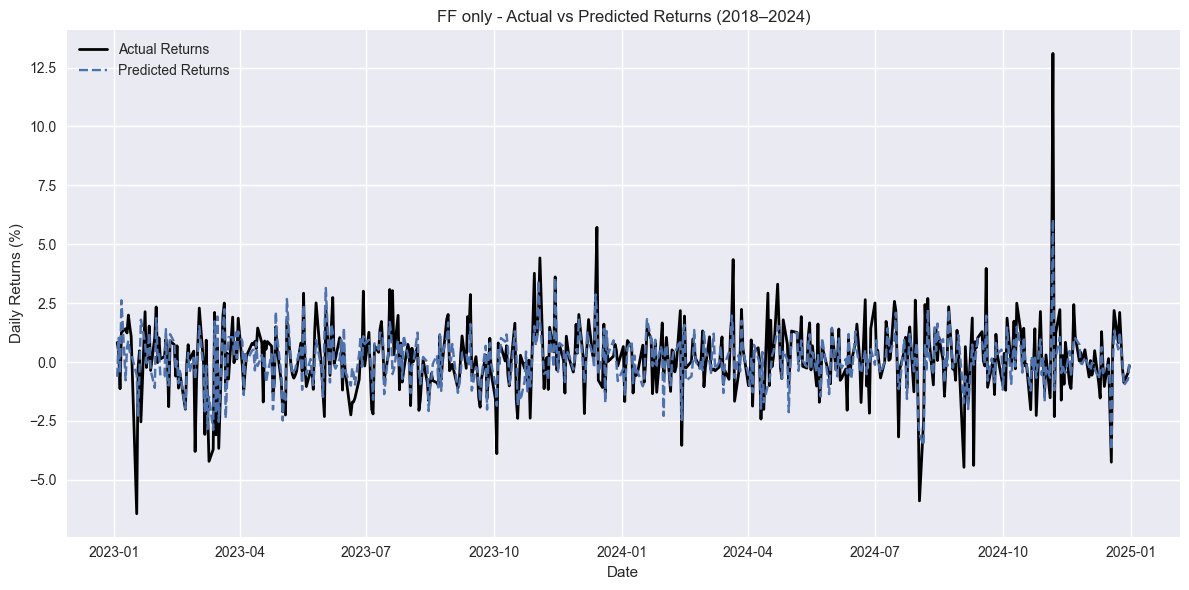


                      FF + AI + General Model (2018–2024)                       


=== FF + AI + General Regression Results ===
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     1108.
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        01:22:11   Log-Likelihood:                -1893.3
No. Observations:                1258   AIC:                             3795.
Df Residuals:                    1254   BIC:                             3815.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.97

/Users/quynhanh2004/miniconda3/envs/d2l/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


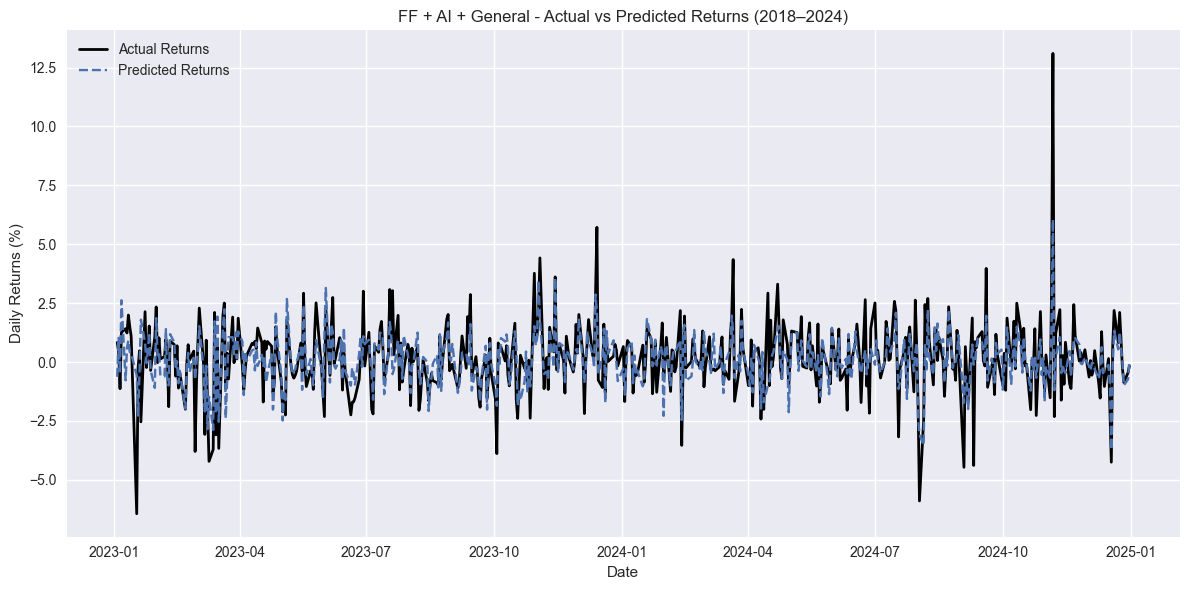


                      FF + ESG + General Model (2018–2024)                      


=== FF + ESG + General Regression Results ===
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     664.2
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        01:22:12   Log-Likelihood:                -1893.1
No. Observations:                1258   AIC:                             3798.
Df Residuals:                    1252   BIC:                             3829.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.9

/Users/quynhanh2004/miniconda3/envs/d2l/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


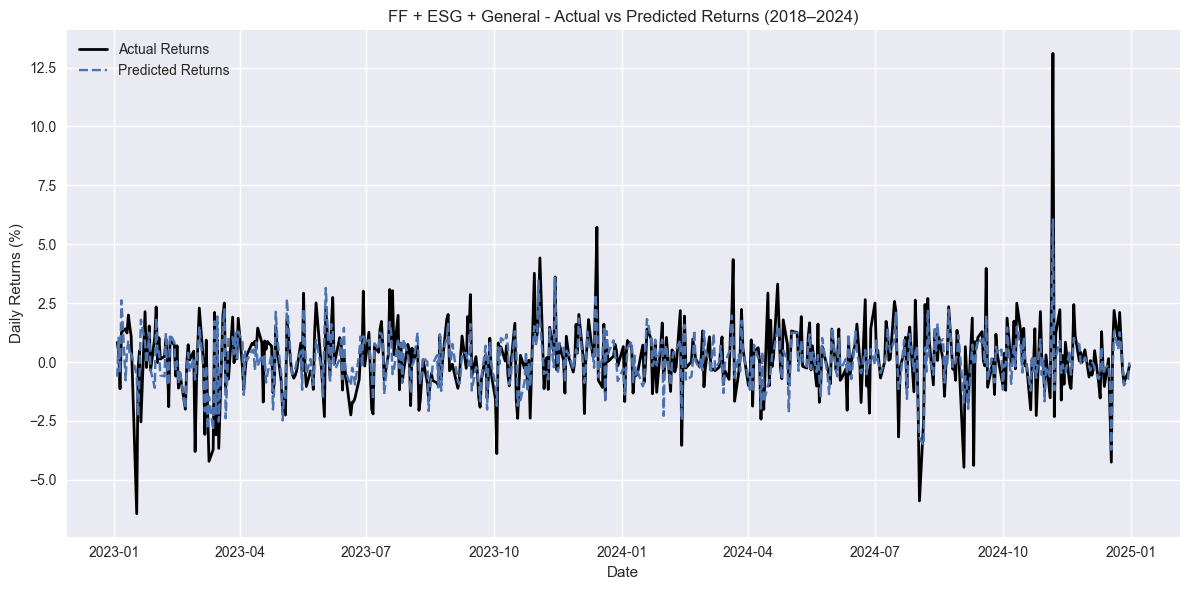


                        FF + Combined Model (2018–2024)                         


=== FF + Combined Regression Results ===
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     830.8
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        01:22:13   Log-Likelihood:                -1893.1
No. Observations:                1258   AIC:                             3796.
Df Residuals:                    1253   BIC:                             3822.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

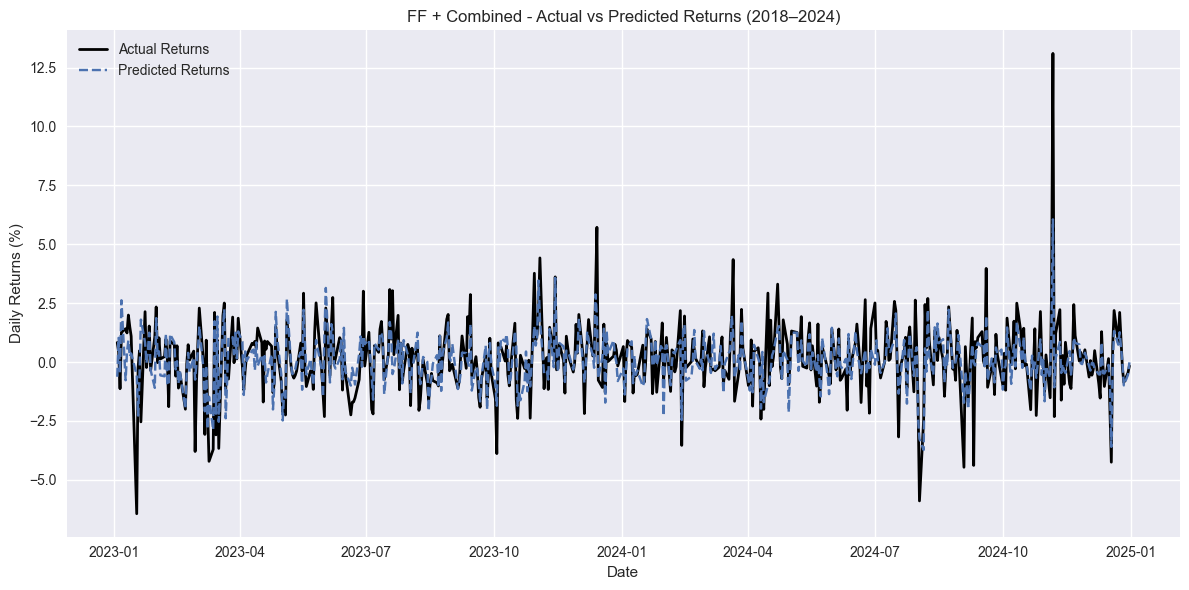


                          Full Model Model (2018–2024)                          


=== Full Model Regression Results ===
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     664.2
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        01:22:14   Log-Likelihood:                -1893.1
No. Observations:                1258   AIC:                             3798.
Df Residuals:                    1252   BIC:                             3829.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----

/Users/quynhanh2004/miniconda3/envs/d2l/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


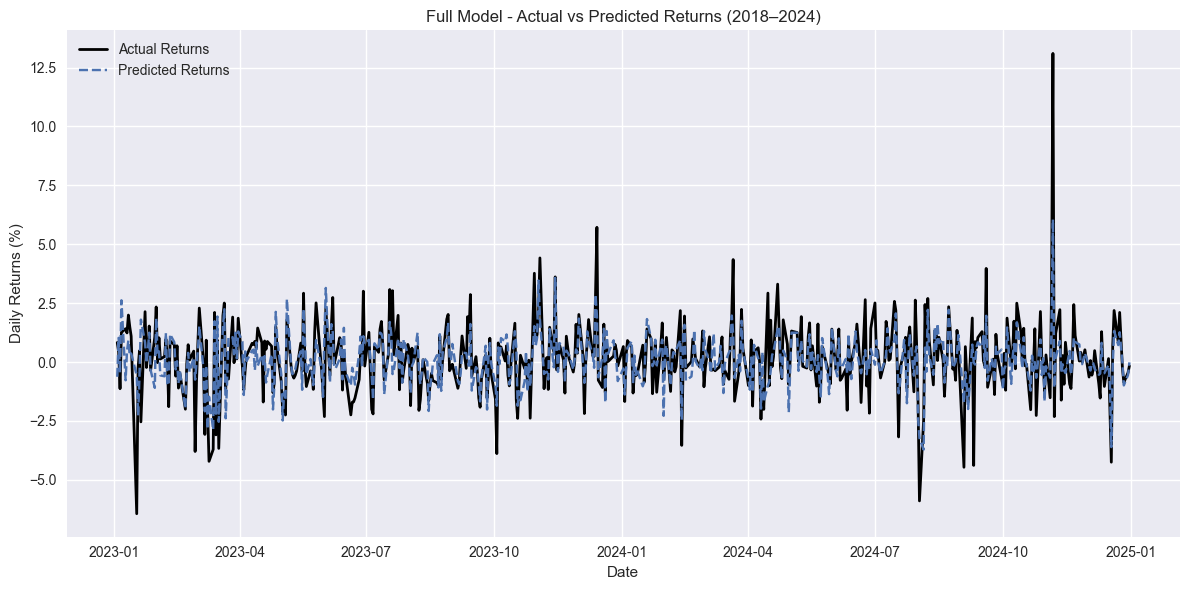

In [6]:

# ======================================================================
# 4. Modeling Loop
# ======================================================================
for config in model_configs:
    print(f"\n{'='*80}")
    print(f"{config['name']} Model (2018–2024)".center(80))
    print(f"{'='*80}\n")
    
    X_train_set = X_train[config['features']]
    X_test_set = X_test[config['features']]
    
    # Statsmodels OLS
    X_train_sm = sm.add_constant(X_train_set)
    sm_model = sm.OLS(y_train, X_train_sm).fit()
    model_summaries[config['name']] = sm_model
    
    # Print summary
    print(f"\n=== {config['name']} Regression Results ===")
    print("="*64)
    print(sm_model.summary())
    
    # Predictions
    y_train_pred = sm_model.predict(X_train_sm)
    y_test_pred = sm_model.predict(sm.add_constant(X_test_set))
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual Returns', color='black', linewidth=2)
    plt.plot(y_test.index, y_test_pred, label='Predicted Returns', linestyle='--')
    plt.title(f"{config['name']} - Actual vs Predicted Returns (2018–2024)")
    plt.xlabel('Date')
    plt.ylabel('Daily Returns (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plot_path = os.path.join(PLOT_DIR, f"returns_{config['name'].replace(' ', '_')}.png")
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()



In [7]:
# ======================================================================
# 5. Performance Comparison Table
# ======================================================================
results = []
for name, model in model_summaries.items():
    config = next(c for c in model_configs if c['name'] == name)
    X_test_set = X_test[config['features']]
    y_test_pred = model.predict(sm.add_constant(X_test_set))
    
    results.append({
        'Model': name,
        'Train R²': model.rsquared,
        'Test R²': r2_score(y_test, y_test_pred),
        'Train MSE': mean_squared_error(y_train, model.fittedvalues),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'AIC': model.aic,
        'BIC': model.bic,
        'AI Days': X_test['include_AI'].sum() if 'ai' in config['features'] else 'N/A',
        'ESG Days': X_test['include_ESG'].sum() if 'esg' in config['features'] else 'N/A',
        'General Days': X_test['include_General'].sum() if 'general' in config['features'] else 'N/A'
    })

# Create and style results DataFrame
results_df = pd.DataFrame(results)

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

print("\n📊 Model Performance Comparison (2018-2024)")
display(results_df.style\
    .apply(highlight_max, props='color:white;background-color:darkblue', subset=['Train R²', 'Test R²'])\
    .apply(highlight_max, props='color:white;background-color:darkred', subset=['Train MSE', 'Test MSE'], axis=1)\
    .apply(highlight_max, props='color:white;background-color:darkgreen', subset=['AIC', 'BIC'], axis=0)\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#4472C4'), 
                 ('color', 'white'),
                 ('font-weight', 'bold')]
    }])\
    .format({
        'Train R²': '{:.4f}',
        'Test R²': '{:.4f}',
        'Train MSE': '{:.6f}',
        'Test MSE': '{:.6f}',
        'AIC': '{:.2f}',
        'BIC': '{:.2f}'
    }))

print("\n✅ Analysis complete. Results saved to:", PLOT_DIR)


📊 Model Performance Comparison (2018-2024)


,Model,Train R²,Test R²,Train MSE,Test MSE,AIC,BIC,AI Days,ESG Days,General Days
0,FF only,0.7261,0.5610,1.187839,1.080545,3794.60,3815.15,N/A,N/A,N/A
1,FF + AI + General,0.7261,0.5610,1.187839,1.080545,3794.60,3815.15,27.000000,N/A,0.000000
2,FF + ESG + General,0.7262,0.5595,1.187427,1.084314,3798.16,3828.98,N/A,26.000000,0.000000
3,FF + Combined,0.7262,0.5591,1.187537,1.085363,3796.28,3821.96,N/A,N/A,N/A
4,Full Model,0.7262,0.5596,1.187427,1.083976,3798.16,3828.98,27.000000,26.000000,0.000000



✅ Analysis complete. Results saved to: ./results/plots
